<a href="https://colab.research.google.com/github/ChiaraCampagnola/clutrr-LSTMvsGNN/blob/main/16129409_ucldm_rl2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL homework 2
**Due date: 30th March 2021, 4:00pm **

Name: ***Chiara Campagnola***

Student number: ***16129409***

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<student_id>_ucldm_rl2.ipynb`** before the deadline above.

## Context

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [1]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [2]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Some grid worlds

In [3]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


In [4]:
SMALL_GRID_LAYOUT = np.array([
  [W, W, W, W, W],
  [W, W, 3, W, W],
  [W, W, 0, W, W],
  [W, 1, 0, W, W],
  [W, W, 0, W, W],
  [W, W, 0, 4, W],
  [W, W, W, W, W]
])


def plot_small_grid(version=1):
  plt.imshow(SMALL_GRID_LAYOUT < -1, interpolation='nearest', cmap='pink_r',
             vmin=-0.2, vmax=1.2)
  if version == 1:
    plt.text(2, 1, '$+3$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+4$', ha='center', va='center', fontsize=12)
  else:
    plt.text(2, 1, '$+2$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+5$', ha='center', va='center', fontsize=12)
  plt.text(2, 3, '$S$', ha='center', va='center', fontsize=12)
  h, w = SMALL_GRID_LAYOUT.shape
  for r in np.arange(0.5, h):
    plt.plot([-0.5, w - 0.5], [r, r], '-k', lw=3, alpha=0.4)
  for c in np.arange(0.5, w):
    plt.plot([c, c], [-0.5, h - 0.5], '-k', lw=3, alpha=0.4)
  plt.xticks([]); plt.yticks([]);

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [5]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward
    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])


def colorline(x, y, z):
    """
    Based on:
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=plt.get_cmap('copper_r'),
                              norm=plt.Normalize(0.0, 1.0), linewidth=3)

    ax = plt.gca()
    ax.add_collection(lc)
    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plotting_helper_function(_x, _y, title=None, ylabel=None):
  z = np.linspace(0, 0.9, len(_x))**0.7
  colorline(_x, _y, z)
  plt.plot(0, 0, '*', color='#000000', ms=20, alpha=0.7, label='$w^*$')
  plt.plot(1, 1, '.', color='#ee0000', alpha=0.7, ms=20, label='$w_0$')
  min_y, max_y = np.min(_y), np.max(_y)
  min_x, max_x = np.min(_x), np.max(_x)
  min_y, max_y = np.min([0, min_y]), np.max([0, max_y])
  min_x, max_x = np.min([0, min_x]), np.max([0, max_x])
  range_y = max_y - min_y
  range_x = max_x - min_x
  max_range = np.max([range_y, range_x])
  plt.arrow(_x[-3], _y[-3], _x[-1] - _x[-3], _y[-1] - _y[-3], color='k',
            head_width=0.04*max_range, head_length=0.04*max_range,
            head_starts_at_zero=False)
  plt.ylim(min_y - 0.2*range_y, max_y + 0.2*range_y)
  plt.xlim(min_x - 0.2*range_x, max_x + 0.2*range_x)
  ax = plt.gca()
  ax.ticklabel_format(style='plain', useMathText=True)
  plt.legend(loc=2)
  plt.xticks(rotation=12, fontsize=10)
  plt.yticks(rotation=12, fontsize=10)
  plt.locator_params(nbins=3)
  if title is not None:
    plt.title(title, fontsize=20)
  if ylabel is not None:
    plt.ylabel(ylabel, fontsize=20)
  

# Section 1: Tabular RL _(60 pts in total for the whole section)_

In this section, observations will be states in the environment, so the agent state, environment state, and observation will all be the same, and we will use the word `state` interchangably with `observation`.  You will implement agents, which should be in pure Python - so you cannot use JAX/TensorFlow/PyTorch to compute gradients. Using `numpy` is fine.

## Q1: A small grid world _(10 pts in total)_

Consider the grid MDP below:

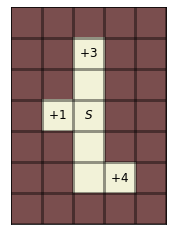

In [6]:
plot_small_grid()

The agent starts at the state marked $S$, and  can move up, left, right, or down.  Whenever it enters a cell with a positive number, the agent receives that reward and the episode terminates.
### Q1.1 [**3 pts**]
Use the code below to plot the value of the optimal policy from the starting state, $v_*(S)$, as a function of the discount factor $\gamma$.

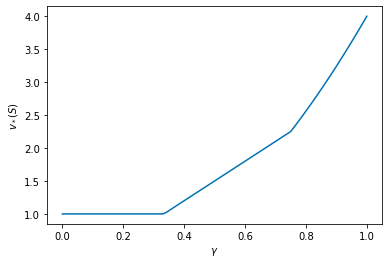

In [11]:
def v(discount):

  return max(1, discount*3, discount*discount*4)
# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v(g) for g in discounts])
  plt.xlabel('$\gamma$')
  plt.ylabel('$v_*(S)$')

plot_v()

### Q1.2 [**2 pts**]

Specify the optimal policy, as a function of $\gamma$.

### Answer

> It takes one step to get to the +1 cell, 2 steps for the +3 cell and 3 steps for the +4 cell. If we call $G_{[x]}$ the return obtained when choosing to go to cell $x$ (starting from $S$), the possible returns are:
>
> - $G_{[+1]} = 1$
> - $G_{[+3]} = 0+3\gamma$
> - $G_{[+4]} = 0+0+4\gamma^2$
>
> At $\gamma = 0$ we should clearly prefer going to +1
>
> If we start increasing $\gamma$, the points at which the policy changes are:
> - $1=3\gamma \implies \gamma = \frac{1}{3}$: this is the point at which we switch from choosing +1 to choosing +3
> - $3\gamma = 4\gamma^2 \implies \gamma = \frac{3}{4}$: from this point we start choosing to go to +4.
>
> So overall:
> - $\pi_*\left(S,\gamma \in [0,\frac{1}{3}]\right)=$ go to +1
> - $\pi_*\left(S,\gamma \in (\frac{1}{3}, \frac{3}{4}]\right)=$ go to +3
> - $\pi_*\left(S,\gamma \in (\frac{3}{4}, 1]\right)=$ go to +4



### Q1.3 [**2 pts**]
Consider the variation of this problem shown in the next plot.

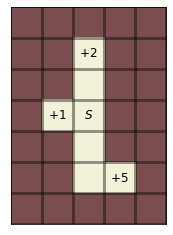

In [7]:
plot_small_grid(version=2)

Suppose a behavioural scientist was doing an experiment where they gave rewards to an animal.  Suppose the setting was as depicted above, where the rewards for instance correspond to food or some other kind of treat (e.g., 5 food pellets at the location marked $+5$). It turns out that, after repeatedly exploring the grid, the animal seems to prefer going up to the reward of $+2$.

Prove that in the MDP depicted above no scalar discount $\gamma \in [0, 1]$ exists for which the optimal policy is to go to $+2$.

### Answer

> We can easily plot the policy values for going to +1, +2 and +5 (from S) as a function of $\gamma$ and see that the value of going to +2 (green line) is never the highest of the three, so we should never pick it.
>
>The optimal policy would be to go to +1 if $\gamma \in[0,\frac{1}{\sqrt{5}}]$ and to +5 if $\gamma \in (\frac{1}{\sqrt{5}},1]$. [Dashed black line indicates $\gamma = \frac{1}{\sqrt{5}}$].
>
> ![image](https://i.ibb.co/1G6TVbd/1-3-fix.png")
>
> Mathematically:
> - +2 beats +1 when $2\gamma > 1 \implies \gamma>\frac{1}{2}$
> - +2 beats +5 when $2\gamma > 5\gamma^2 \implies \gamma < \frac{2}{5}$
>
>There is no overlap between these ranges, so there is no value of $\gamma$ for which going to +2 can beat both +1 and +5

### TO DELETE

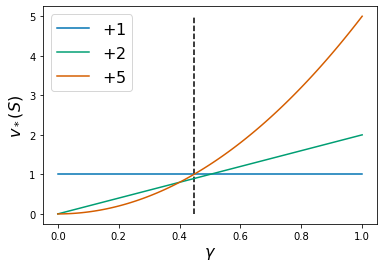

In [16]:
# TO delete

def v1(discount):
    return 1

def v2(discount):
    return 2*discount

def v5(discount):
    return 5*discount*discount

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v1(g) for g in discounts], label='$+1$')
  plt.plot(discounts, [v2(g) for g in discounts], label='$+2$')
  plt.plot(discounts, [v5(g) for g in discounts], label='$+5$')
  plt.vlines(x = 0.447, ymin = 0, ymax = 5, 
           colors = 'black', linestyle='--') 
  plt.xlabel('$\gamma$', fontsize=16)
  plt.ylabel('$v_*(S)$', fontsize=16)
  plt.legend(prop={"size":16})
  plt.show()
plot_v()

### Q1.4 [**3 pts**]
In the same setting as the previous question, now consider the following generalised definition of a Monte Carlo return
\begin{align*}
G_t
& = R_{t+1} + f(R_{t+2} + f(R_{t+3} + f(\ldots))) \\
& = R_{t+1} + f(G_{t+1}) \,,
\end{align*}
In this formulation, we get standard discounting when we define $f(x) = \gamma x$. Consider the following alternative where instead of multiplying with a factor $\gamma$, we raise the value to the power: $f(x) = x^\gamma$.  Does this mathematical model better explain the observed behaviour, in the sense that a $\gamma$ exists for which the optimal policy goes to $+2$?  If so, give such a value for $\gamma$, and prove that the policy of going to $+2$ is optimal with that choice.  If not, prove that no such $\gamma$ exists.


### Answer


> As before, we can plot the value using the new returns:
> - $G_{[+1]} = 1$
> - $G_{[+2]} = 0 + f(2) = 2^\gamma$
> - $G_{[+5]} = 0 + f(0+f(5)) = (5^{\gamma})^\gamma=5^{\gamma^2}$
> And we can see that there is now a range of values of $\gamma$ for which the optimal policy is to go to +2.
>
> ![image](https://i.ibb.co/gmGCdLJ/1-4.png)
>
> Mathematically:
> - +2 beats +1 when $2^\gamma > 1 \implies \gamma > 0$ so in the whole range of $\gamma$ (at $\gamma = 0$ they are equivalent so either could be picked)
> - +2 beats +5 when $2^\gamma > 5^{\gamma^2} \implies \gamma < 0.43$
>
> So in the range $\gamma \in (0, 0.43)$ the optimal policy is to go to +2.


### TO DELETE

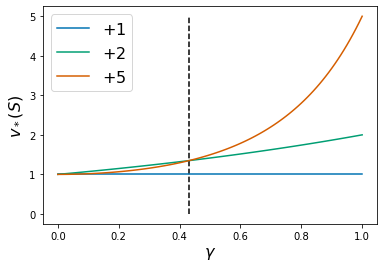

In [21]:
# TO delete

def v1(discount):
    return 1

def v2(discount):
    return 2**discount

def v5(discount):
    return 5**(discount*discount)

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v1(g) for g in discounts], label='$+1$')
  plt.plot(discounts, [v2(g) for g in discounts], label='$+2$')
  plt.plot(discounts, [v5(g) for g in discounts], label='$+5$')
  plt.vlines(x = 0.43, ymin = 0, ymax = 5, 
           colors = 'black', linestyle='--') 
  plt.xlabel('$\gamma$', fontsize=16)
  plt.ylabel('$v_*(S)$', fontsize=16)
  plt.legend(prop={"size":16})
  plt.show()
plot_v()

# Implementing algorithms

**Minimal agent interface**:

Each agent should implement the following methods:

### `__init__(self, number_of_actions, number_of_states, initial_observation, ...)`:
The constructor will provide the agent the number of actions, number of states, and the initial state. You can get the initial state by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`. The constructor may accept additional arguments (denoted here by the ellipsis `...`) depending on the specific algorithm implemented by the agent.

### `step(self, reward, discount, next_state)`:

The step method of an agent should update its internals, in whatever way is appropriate for its learning algorithm, and return a new action to be executed in the environment.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_state` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_state})$" in the update, because $\gamma = 0$ (for whatever definition of $v$ is appropriate---for instance, $v(s)$ could be defined in terms of action values estimates that we are learning, for instance by $v(s) = \max_a q(s, a)$).  Therefore, the end of an episode can be seamlessly handled with the same step function.

**Note on the initial action**:

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state and reward.  In the constructor (`__init__`), make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```
In our experiments the helper functions above will execute the action `0` (which corresponds to `up` in the grid world) as the initial action to begin the run loop of the experiment.  This initial action is only executed once, and the beginning of the very first episode---not at the beginning of each episode.

### A random agent

Below we show a reference implementation of a simple random agent, implemented according to the interface above.

In [ ]:
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### The grid

The cell below shows the `Grid` environment that we will use in this section. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-100` for bumping into a wall, `+100` for reaching the goal, and `-1` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

In [ ]:
grid = Grid()
grid.plot_grid()


## Q2: Implement TD learning **[5 pts]**
Implement an agent that acts randomly, and _on-policy_ estimates state values $v(s)$, using one-step TD learning with step size $\alpha=0.1$.

In addition to the base interface, also implement a property `state_values(self)` returning the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  

**Hint**: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [ ]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  @property
  def state_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    ...

### Run the next cell to run the `RandomTD` agent on a grid world.

If everything worked as expected, the plot below will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange below).

In [ ]:
# Do not modify this cell.
agent = RandomTD(grid._layout.size, 4, grid.get_obs())
run_experiment(grid, agent, int(1e5))
v = agent.state_values
plot_values(GRID_LAYOUT, v.reshape(grid._layout.shape), colormap="hot", vmin=-300, vmax=100)

## Q3: Policy iteration **[5 pts]**
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state and for each action we can look at the value of the resulting state, and would then pick the action with the highest reward plus subsequent state value. In other words, you can assume we can use $q(s, a) = \mathbb{E}[ R_{t+1} + \gamma v(S_{t+1}) \mid S_t = s, A_t = a]$, where $v$ is the value function learned by TD as implemented. Then we consider the policy that picks the action with the highest action value $q(s, a)$. You do **not** have to implement this, just answer the following question.

The above amounts to performing an iteration of policy evaluation and policy improvement.  If we repeat this process over and over again, and repeatedly evaluate the greedy policy and then perform an improvement step by picking the greedy policy, would the policy eventually become optimal?  Explain why or why not in at most three sentences.

> *Answer here*


## Q4: Implement a general Q-learning agent **[15 pts]**
Implement a  **general Q-learning** agent that learns action values from experience.   The agent must act according to an $\epsilon$-greedy policy over its action values.  It must be configurable so as to implement any of **Sarsa**, **Expected Sarsa**, **Q-learning**,  and **double Q-learning**.

The `__init__` must accept two functions `target_policy` and `behaviour_policy` as arguments.   The function `behaviour_policy(action_values)` should map `action_values` to a single action. 

For instance, the random policy can be implemented as:
```
def behaviour_policy(action_values):
  return np.random.randint(len(action_values))
```

The target policy is defined by a function `target_policy(action_values, action)`, which returns **a vector** with one probability per action.  The `action` argument is used for instance by Sarsa (where the target policy is a greedy distribution with its peak on the selected action).

For instance, the random target policy is:
```
def target_policy(action_values, unused_action):
  number_of_actions = len(action_values)
  return np.ones((number_of_actions,))/number_of_actions
```

The `__init__` must also accept  a `double` boolean flag. Note that this is compatible with any choice of `target_policy` and `behaviour_policy`. For instance, if the `target_policy` is the policy described above for Sarsa and `double=True`, the algorithm should implement **double Sarsa**. Note that we then need two action-value functions.

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the update on the first transition in the agent's lifetime.  


In [ ]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state,
               target_policy, behaviour_policy, double, step_size=0.1):
    # Settings.
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    # Initial state.
    self._s = initial_state
    # Tabular q-estimates.
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    # The first action in an agent's lifetime is always 0(=up) in our setup.
    self._last_action = 0

  @property
  def q_values(self):
    return (self._q + self._q2)/2 if self._double else self._q

  def step(self, reward, discount, next_state):
    pass

## Experiment 1: Run the cells below

This will train Q-learning, Sarsa, Expected Sarsa, and double Q-learning agents on the deterministic version of the Grid problem.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [ ]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

In [ ]:
# Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

In [ ]:
# Sarsa
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[a]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

In [ ]:
# Expected Sarsa
# Do not modify this cell.
grid = Grid()
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  greedy = np.eye(len(q))[np.argmax(q)]
  return greedy - greedy*epsilon + epsilon/4 

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

In [ ]:
# Double Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  # Place equal probability on all actions that achieve the `max` value.
  # This is equivalent to `return np.eye(len(q))[np.argmax(q)]` for Q-learning
  # But results in slightly lower variance updates for double Q.
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=True, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-50, vmax=100)

## Q5: Analyse results _(10 pts in total)_

Consider the greedy policy with respect to the estimated values learned by each of the four agents.

**[5 pts]** How and why do the policies found by Q-learning, Sarsa, Expected Sarsa, and double Q-learning differ? Explain notable qualitative differences in at most four sentences.

> *Answer here*

**[5 pts]** Which of the algorithms, out of Q-learning, Sarsa, Expected Sarsa, and double Q-learning with the learning parameters (exploration, step size) as discussed above, will *in general* yield higher returns on average during learning?  You are allowed to specify a partial (rather than a full) ordering over the algorithms, but try to be as specfic as you can. Explain your answer in at most four sentences.

> *Answer here*

## Experiment 2: Run the cells below

This will train Q-learning and double Q-learning agents on the stochastic version of the Grid problem.

In the noisy version, a zero-mean Gaussian is added to all rewards.  

The variance of this noise is higher the further to the left you go, and the further down.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [ ]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

In [ ]:
# Q-learning and double Q-learning.
# Do not modify this cell.

def target_policy(q, a):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)

mean_reward_q_learning = []
mean_reward_double_q_learning = []
for _ in range(30):
  grid = Grid(noisy=True)
  q_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=False, step_size=step_size)
  dq_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=True, step_size=step_size)
  mean_reward_q_learning.append(run_experiment(grid, q_agent, int(2e5)))
  mean_reward_double_q_learning.append(run_experiment(grid, dq_agent, int(2e5)))

plt.violinplot([mean_reward_q_learning, mean_reward_double_q_learning])
plt.xticks([1, 2], ["Q-learning", "Double Q-learning"], rotation=60, size=12)
plt.ylabel("average reward during learning", size=12)
ax = plt.gca()
ax.grid(0)

## Q6: Analyse results **[8 pts]**

Which among Q-learning and Double Q-learning has a higher average reward? Explain why, discussing at least a) the dynamics of the algorithm, b) how this affects behaviour, and c) why the behaviour yields higher rewards for one algorithm rather than the other. Be concise.

> *Answer here*

## Q7: Target Q-learning **[7 pts]**

Consider a new algorithm which we will refer to as **target Q-learning**. The target Q-learning algorithm applies Q-learning updates in the form 
$\ \ q(S_t, A_t) \leftarrow R_{t+1} + \gamma \max_a q'(S_{t+1}, a) \ \ $  
where the values $q'$ have been pre-trained by running $\epsilon$-greedy Expected Sarsa, and are then held fixed throughout training.

We can now imagine now to train both Q-learning and target Q-learning on the deterministic Grid problem.  In both Q-learning and target Q-learning the behaviour policy will select actions based on the same $\epsilon$-greedy policy that was used to pre-train the $q'$ values, but using the current action-value estimates (not the fixed target values $q'$).

Explain concisely which of the two algorithms will perform better and why. (If you're tempted to answer 'it depends', be sure to be clear what you think it depends on, and why. Don't be vague: point could be subtracted for including irrelevant or false statements, even if the correct answer is also given.)

> *Answer here*

# Section 2: Off-policy Bellman operators with function approximation
# _(40 pts total for the whole section)_

## Q8: Bellman operator for prediction **[10 pts]**

We are going to implement a Bellman operator for a simple MDP. You should:


1. Write a value function `v(w, x)` that outputs a linear value estimate when we have weights `w` (a numpy vector) and feature vector `x` (a numpy vector of the same size).
2. Write an operator function `T(w, pi, mu, l, g)` that takes weights `w`, a target policy `pi`, a behaviour policy `mu`, a trace parameter `l`, and a discount `g`, and outputs an off-policy-corrected lambda-return.  For this question, implement the standard importance-weighted per-decision lambda-return. There will only be two actions, with the same policy in each state, so we can define `pi` to be a number which is the target probability of selecting action `a` in any state (s.t. `1 - pi` is the probability of selecting `b`), and similarly for the behaviour `mu`.
3. Write an expected weight update, that uses the above two functions to compute the **expected** weight update.  The expectation should take into account the probabilities of actions in the future, as well as the steady-state (=long-term) probability of being in a state.  The step size of the update should be $\alpha=0.1$.

There are two states, $s_1$ and $s_2$.  All rewards are zero, and therefore can be ignored.  The state features $x_1 = x(s_1)$ and $x_2 = x(s_2)$ for the two states are $x_1 = [1, 1]^{\top}$ and $x_2 = [2, 1]^{\top}$.  In each state, there are two actions, $a$ and $b$.  Action $a$ always transitions to state $s_1$, action $b$ always transitions to state $s_2$.

![MDP](https://hadovanhasselt.files.wordpress.com/2020/02/mdp.png)


In [ ]:
# state features (do not change)
x1 = np.array([1., 1.])
x2 = np.array([2., 1.])

def v(w, x):
  pass

def T(w, pi, mu, l, g):
  pass

def expected_update(w, pi, mu, l, g, lr):
  pass

##Experiment 3: run the cell below
The cell below runs an experiment, across different target policies and trace parameters $\lambda$.

The plots below the cell will show how the weights move within the 2-dimensional weight space, starting from $w_0 = [1, 1]^{\top}$ (shown as red dot).  The optimal solution $w_* = [0, 0]^{\top}$ is also shown (as black star).

In [ ]:
def generate_ws(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + expected_update(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

mu = 0.5  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

## Q9: Analyse results (30 pts total)
1. **[2 pts]** How many of the above 25 experiments diverge?
1. **[4 pts]** Why are the results asymmetric across different $\pi$?  In particular, explain why the results look different when comparing $\pi = \pi(a | \cdot) = 0$ to $\pi(a | \cdot) = 1$.
1. **[4 pts]** For which policies $\pi$, is the true value function $v_{\pi}$ representable in the above feature space (spanned by $x_1, x_2$).
1. **[4 pts]** For which combination of $\pi(a)$ and $\lambda$ does the expected update (with uniform random behaviour) converge? (Do not limit the answer to the subset of values in the plots above, but to all choices of $\lambda$ and $\pi$, but do restrict yourself to state-less policies, as above, for which the action probabilities are equal in the two states.)
1. **[4 pts]** Why do all the plots corresponding to full Monte Carlo look the same?
1. **[4 pts]** Why do the plots corresponding to full Monte Carlo have the shape they do?
1. **[4 pts]** How would the results above change (at high level, not in terms of precise plots) if the behaviour policy $\mu$ would select action $a$ more often (e.g., $\mu = 0.8$)?  How would the results change if the behaviour would select $a$ less often (e.g., $\mu = 0.2$)?
1. **[4 pts]** Consider again the orginal experiment, where data is gathered under uniformly random behaviour policy. What would the updates to the vectors $w$ be under the $L_\infty$ norm? You can either run the experiment or give the closed-form update in an equation.


## Put answers to Q9 in this cell:
1. _...answer here..._
2. _...answer here..._
3. _...answer here..._
4. _...answer here..._
5. _...answer here..._
6. _...answer here..._
7. _...answer here..._
8. _...answer here..._